In [219]:
import pandas as pd
import numpy as np
import jieba
import seaborn as sns
import matplotlib.pyplot as plt

In [220]:
results = pd.read_csv("../data/retrieval_results/oasst2_filtered_distiluse-base-multilingual-cased-v2.csv", index_col=0)

In [221]:
results

,lang,message_id,parent_id,user_id,created_date,query,answer,review_count,answer_len,nearest_neighbor_text,nearest_neighbor_score,nearest_neighbor_lang
0,en,b7efe31a-d590-45ca-8d2c-bbac8fa3953c,00353343-a4a5-4fb0-96fd-02f529a55181,1aaa9be1-0d07-4cb2-a2d7-4301cbfc4ecc,2023-02-16T05:03:16.550139+00:00,"I am making mayonnaise, it was starting to thi...","Yes, it's possible to fix runny mayonnaise! Th...",3,144,The Perfect Egg Recipe with Olive Oil and Lemo...,0.869131,en
1,en,041bb9df-c2a9-4156-8b5c-f743d45ebef0,e907161e-cd3b-44a6-b071-7cd0074bea25,0cae2539-a148-45e6-90ea-2a8c34fc7c9c,2023-02-17T02:09:03.828592+00:00,What is optimal Mayonnaise thickness?,The optimal mayonnaise thickness will depend o...,3,52,There are different ways to assemble a sandwic...,0.794854,en
2,en,dfc197d6-f869-482f-9068-b7aa526739ae,e907161e-cd3b-44a6-b071-7cd0074bea25,2d40e94c-40ed-4e00-a66e-454c0401c8ad,2023-02-17T01:56:40.836060+00:00,What is optimal Mayonnaise thickness?,The optimal thickness of mayonnaise can vary d...,3,96,"If you are a fan of spicy food, you probably k...",0.834026,en
3,en,f159369c-4725-4b46-96aa-c643ce92e292,00353343-a4a5-4fb0-96fd-02f529a55181,df411b83-5030-4708-bf81-0fe9fa1398b2,2023-02-16T03:34:04.565889+00:00,"I am making mayonnaise, it was starting to thi...","Yes, it is possible to salvage your mayonnaise...",3,90,The Perfect Egg Recipe with Olive Oil and Lemo...,0.818597,en
4,en,03d70f1b-4efb-4ab3-8832-41b14709b44c,00353343-a4a5-4fb0-96fd-02f529a55181,b21ee06a-3b13-43b9-8a3e-f88a1794eddb,2023-02-16T09:00:06.418104+00:00,"I am making mayonnaise, it was starting to thi...",You'll probably want to either add a proper ra...,3,25,Place the ingredients in a bowl in the amounts...,0.760955,en
...,...,...,...,...,...,...,...,...,...,...,...,...
54870,zh,378c1ca7-fd52-4951-982b-45bc1e8b0423,6a2c699a-01df-4cb0-85b6-08147eb1d08c,f3bcacd0-9e1e-4f9f-81b3-2a025401d987,2023-05-01T14:46:39.390439+00:00,有哪些学习音乐理论知识的资源？,学习音乐理论知识的资源很多，以下是一些常用的资源：\n\n1. 音乐学院/音乐学校：如果你想...,5,334,Some measures being taken to increase music ed...,0.723500,en
54871,zh,ca68c653-ac78-458c-a638-bb2a13fc9a61,6a2c699a-01df-4cb0-85b6-08147eb1d08c,c3c524d7-ec16-48b8-b3d7-35310451224f,2023-05-01T08:42:40.542449+00:00,有哪些学习音乐理论知识的资源？,如果你想要学习更多有关乐理的知识，那么你可以尝试使用网站或app。\n### 网站 或者AP...,5,285,Hay varias formas en que la tecnología puede s...,0.732545,es
54872,zh,1205808b-f8f5-4890-91e7-feb4395cfbd4,fcf702bc-9ed9-4fb7-a263-9e0e5013dd46,c3c524d7-ec16-48b8-b3d7-35310451224f,2023-05-04T11:35:55.413702+00:00,没有，我只有基础的乐理知识。,建议您可以从以下几个方面入手:\n1. 聆听更多交响乐作品。\n2. 学习各种交响乐器的技巧...,5,78,"To play a musical instrument, you need to:\n\n...",0.793127,en
54873,zh,bcb3062e-e82e-4908-92aa-5b99d765eba9,fcf702bc-9ed9-4fb7-a263-9e0e5013dd46,0efa9297-781d-4b30-b5a6-8fd1e9625059,2023-05-10T18:34:58.694482+00:00,没有，我只有基础的乐理知识。,那好吧，我会给你介绍一些基础的乐理知识，并尽可能用通俗易懂的表达来帮助你理解这些知识。\n\...,0,41,كـذكـرىيـةًٌ، انا كـذكـاءة اصطنـاعيـة ولا أستط...,0.603571,ar


In [222]:
def calculate_fpr(results_df: pd.DataFrame, threshold: float=0.95) -> float:
    false_positives = (results_df["nearest_neighbor_score"] >= threshold).sum()
    false_positive_rate = np.round(false_positives / len(results_df), 3)
    return false_positive_rate * 100

In [223]:
def fpr_for_specific_languages(results):
    languages_fprs = {}
    for lang in results["lang"].unique():
        language_results = results[results["lang"] == lang]
        fpr = calculate_fpr(language_results)
        languages_fprs[lang] = fpr
    
    return languages_fprs

In [224]:
def fpr_for_specific_threshold(results, threshold):
    fpr = calculate_fpr(results, threshold)
    return fpr

In [225]:
def percentage_different_language_nearest_neighbor(results, target_language):
    language_results = results[results["lang"] == target_language]
    different_language_count = sum(language_results["lang"] != language_results["nearest_neighbor_lang"])
    percentage = (different_language_count / len(language_results)) * 100
    return percentage

In [226]:
def count_shared_words_and_set(results):
    shared_words_count = []
    shared_words_list = []
    for index, row in results.iterrows():
        if row["lang"] == "zh" or row["nearest_neighbor_lang"] == "zh":
            answer_words = set(filter(lambda x: x.strip(), jieba.lcut(row["answer"])))
            neighbor_words = set(filter(lambda x: x.strip(), jieba.lcut(row["nearest_neighbor_text"])))
        else:
            answer_words = set(row["answer"].split())
            neighbor_words = set(row["nearest_neighbor_text"].split())
        shared_words = list(answer_words.intersection(neighbor_words))
        shared_words_count.append(len(shared_words))
        shared_words_list.append(shared_words)
    return shared_words_count, shared_words_list

In [227]:
def correlation_nearest_neighbor_length_score(results):
    correlation = results["nearest_neighbor_text"].apply(lambda x: len(x.split(" "))).corr(results["nearest_neighbor_score"])
    return correlation

In [228]:
def plot_correlation_shared_words_score(results):
    shared_words_count, shared_words_list = count_shared_words_and_set(results)
    results["shared_words_between_answer_and_neighbor"] = shared_words_count
    results["shared_words_between_answer_and_neighbor"] = shared_words_count
    sns.scatterplot(x="shared_words_between_answer_and_neighbor", y="nearest_neighbor_score", data=results, alpha=0.5)
    plt.xlabel("Number of shared words between candidate and nearest neighbor")
    plt.ylabel("Nearest Neighbor Score")
    plt.title("Correlation between the number of shared words between candidate and nearest neighbor and similarity")
    plt.show()

In [229]:
def plot_correlation_nearest_neighbor_length_score(results):
    results["neighbor_text_length"] = results["nearest_neighbor_text"].apply(lambda x: len(x.split(" ")))
    sns.scatterplot(x="neighbor_text_length", y="nearest_neighbor_score", data=results)
    plt.xlabel("Length of Nearest Neighbor Text")
    plt.ylabel ("Nearest Neighbor Score")
    plt.title("Correlation between Nearest Neighbor Text Length and Score")
    plt.xlim(0, 500)
    plt.show()

In [230]:
def plot_similarity_score_distribution(results):
    sns.histplot(results["nearest_neighbor_score"], bins=20, kde=True)
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Similarity Score Distribution")
    plt.show()

### Correlations

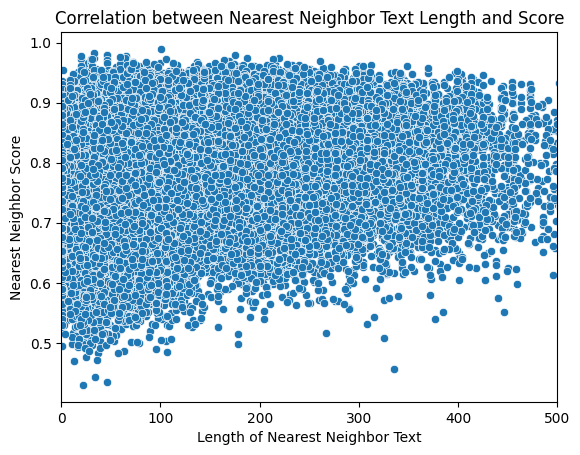

In [231]:
plot_correlation_nearest_neighbor_length_score(results)

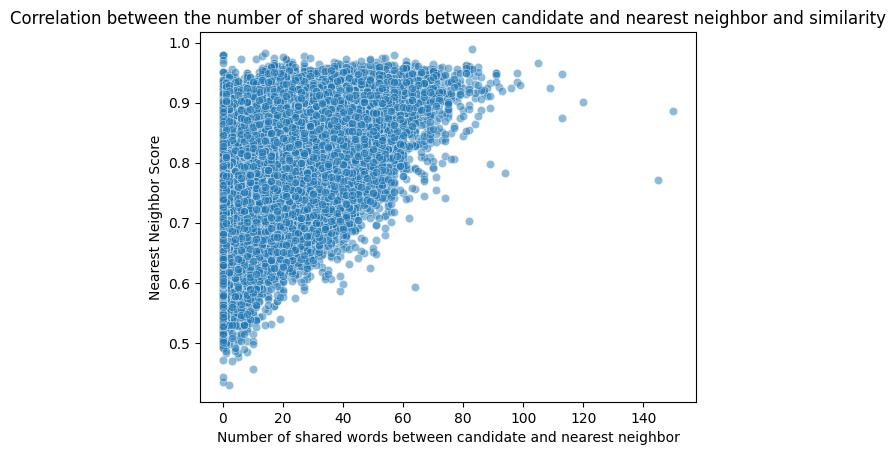

In [232]:
plot_correlation_shared_words_score(results)

In [233]:
correlation_nearest_neighbor_length_score(results)

0.21957724803156162

### Distributions

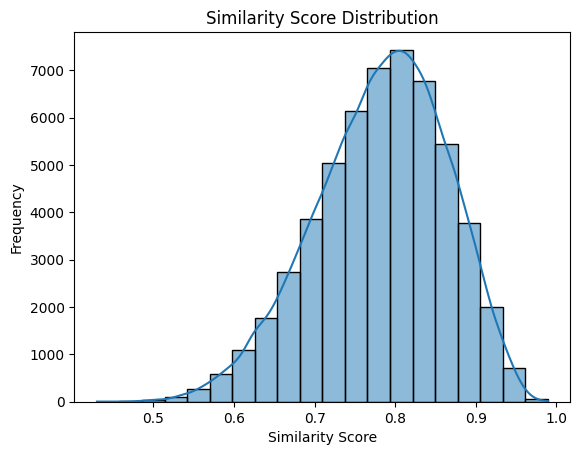

In [234]:
plot_similarity_score_distribution(results)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


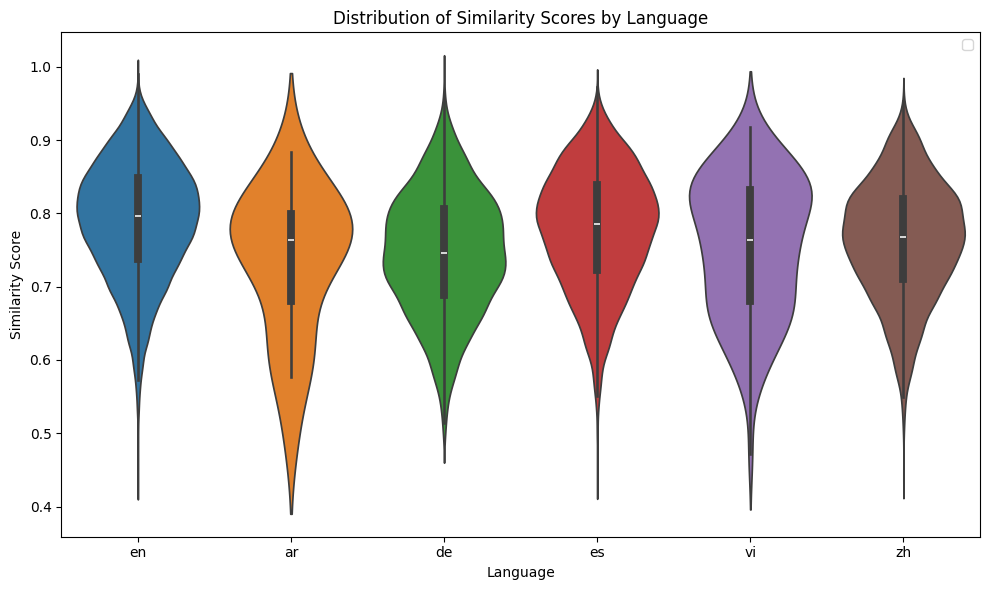

In [235]:
def plot_similarity_scores_by_language(results_df):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="lang", y="nearest_neighbor_score", hue="lang", data=results_df)
    plt.xlabel("Language")
    plt.ylabel("Similarity Score")
    plt.title("Distribution of Similarity Scores by Language")
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_similarity_scores_by_language(results)

### Different language of neighbor than the language of answer

In [236]:
def percentage_different_language_nearest_neighbor(results):
    language_percentages = {}
    for lang in results["lang"].unique():
        language_results = results[results["lang"] == lang]
        different_language_count = sum(language_results["lang"] != language_results["nearest_neighbor_lang"])
        total_count = len(language_results)
        percentage = (different_language_count / total_count) * 100
        language_percentages[lang] = percentage
    
    return language_percentages

def plot_language_percentages(language_percentages):
    plt.figure(figsize=(10, 6))
    plt.bar(language_percentages.keys(), language_percentages.values(), color="skyblue")
    plt.xlabel("Language")
    plt.ylabel("Percentage of Different Nearest Neighbors (%)")
    plt.legend()
    plt.title("Percentage of Different Nearest Neighbors by Language")
    plt.xticks(rotation=45, ha="right")
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


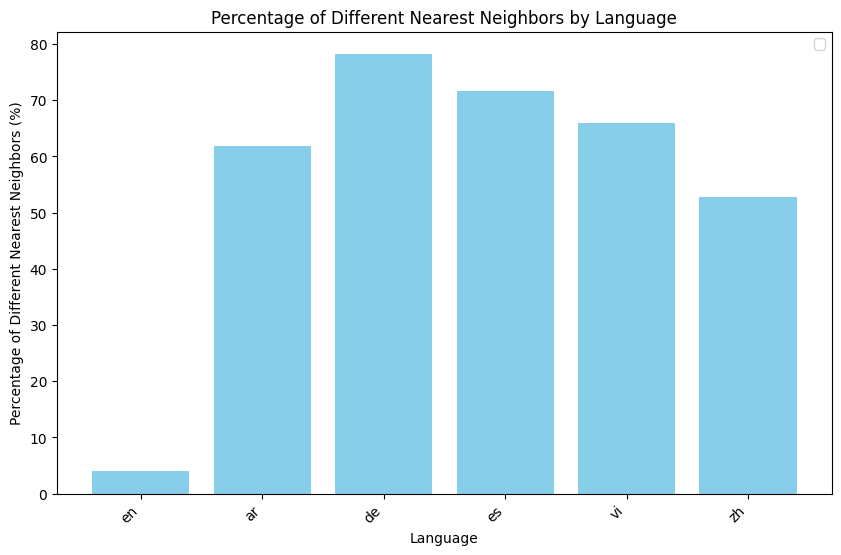

In [237]:
different_neighbor_language_percentages = percentage_different_language_nearest_neighbor(results)
plot_language_percentages(different_neighbor_language_percentages)

### FPR per language

In [238]:
def plot_language_fprs(language_fprs):
    plt.figure(figsize=(10, 6))
    plt.bar(language_fprs.keys(), language_fprs.values(), color="skyblue")
    plt.xlabel("Language")
    plt.ylabel("False Positive Rate (%)")
    plt.title("False Positive Rate by Language")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

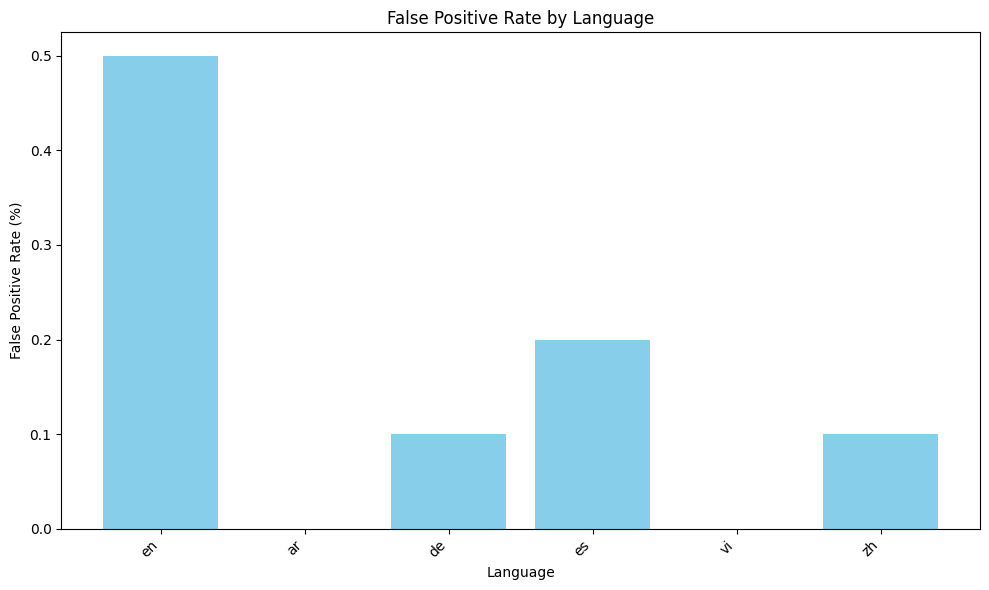

In [239]:
language_fprs = fpr_for_specific_languages(results)
plot_language_fprs(language_fprs)

### FPR for specific thresholds

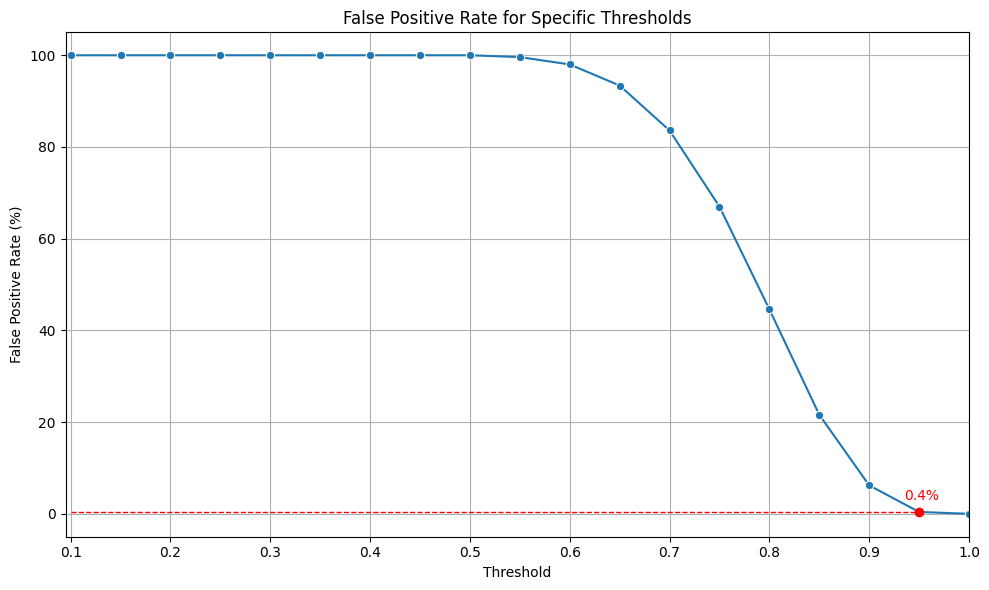

In [240]:
def fpr_for_specific_thresholds(results_df):
    thresholds = np.arange(0.1, 1.1, 0.05)
    fprs = [calculate_fpr(results_df, threshold) for threshold in thresholds]
    return thresholds, fprs

def plot_fpr_for_specific_thresholds(thresholds, fprs):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=thresholds, y=fprs, marker="o")
    plt.xlabel("Threshold")
    plt.ylabel("False Positive Rate (%)")
    plt.title("False Positive Rate for Specific Thresholds")
    plt.xticks(np.arange(0.1, 1.1, 0.1))
    plt.xlim(0.095, 1)
    plt.grid(True)

    idx_095 = np.where(np.round(thresholds, 2) == 0.95)[0].item()
    fpr_095 = fprs[idx_095]

    plt.scatter(0.95, fpr_095, color="red", zorder=5)
    plt.text(0.97, fpr_095 + 2, f"{fpr_095:.1f}%", ha="right", va="bottom", color="red")
    plt.plot([0.1, 0.95], [fpr_095, fpr_095], color="red", linestyle="--", linewidth=1)
    plt.tight_layout()
    plt.show()

thresholds, fprs = fpr_for_specific_thresholds(results)
plot_fpr_for_specific_thresholds(thresholds, fprs)

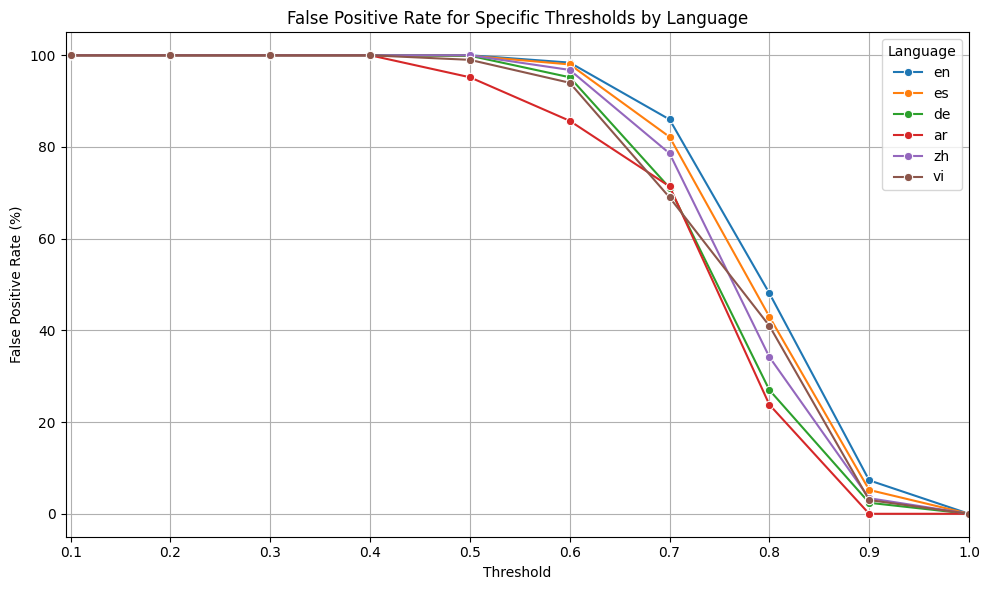

In [241]:
def fpr_for_specific_thresholds_and_language(results_df, target_language):
    thresholds = np.arange(0.1, 1.1, 0.1)
    fprs = [calculate_fpr(results_df[results_df["lang"] == target_language], threshold) for threshold in thresholds]
    return thresholds, fprs

def plot_fpr_for_specific_thresholds_multiple_languages(results_df, target_languages):
    plt.figure(figsize=(10, 6))
    for lang in target_languages:
        thresholds, fprs = fpr_for_specific_thresholds_and_language(results_df, lang)
        sns.lineplot(x=thresholds, y=fprs, marker="o", label=lang)

    plt.xlabel("Threshold")
    plt.ylabel("False Positive Rate (%)")
    plt.title("False Positive Rate for Specific Thresholds by Language")
    plt.xticks(np.arange(0.1, 1.1, 0.1))
    plt.xlim(0.095, 1)
    plt.grid(True)
    plt.legend(title="Language")
    plt.tight_layout()
    plt.show()

# Example usage
target_languages = ["en", "es", "de", "ar", "zh", "vi"]
plot_fpr_for_specific_thresholds_multiple_languages(results, target_languages)